In [40]:
import scanpy as sc  # For single-cell RNA-seq data analysis.
import scipy.stats as stats # For scientific computing.
import numpy as np  # For numerical computing.
import infercnvpy as cnv  # For inferCNV analysis.
import matplotlib.pyplot as plt # For plotting.
import seaborn as sns # For plotting.

In [6]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"

In [7]:
adata = sc.read_h5ad(f'{base_data_path}/infer_cnv_completed.h5ad')
adata

AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type', 'cnv_leiden', 'cnv_score'
    var: 'n_cells', 'chromosome', 'start', 'end'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [8]:
# Check if 'PLAUR' exists in the gene names of the dataset
if 'PLAUR' in adata.var_names:
    
    # Extract PLAUR expression data (using raw counts or a relevant layer if specified)
    plaured_raw_expr = adata[:, 'PLAUR'].X

    # Convert to a dense array if PLAUR expression data is sparse
    if scipy.sparse.issparse(plaured_raw_expr):
        plaured_raw_expr = plaured_raw_expr.toarray().flatten()  # Convert and flatten array
    else:
        plaured_raw_expr = plaured_raw_expr.flatten()            # Flatten directly if already dense

    # Create a binary status column in adata.obs based on PLAUR expression levels
    # Values greater than 0 are labeled 'PLAUR+', while others are labeled 'PLAUR-'
    adata.obs['PLAUR_Status_Binary'] = np.where(plaured_raw_expr > 0, 'PLAUR+', 'PLAUR-')

    # Confirm the addition by displaying counts of PLAUR+ and PLAUR- cells
    print("PLAUR_Status_Binary column added to adata.obs:")
    print(adata.obs['PLAUR_Status_Binary'].value_counts())

else:
    # Raise an error if PLAUR is not found in the gene list of the dataset
    raise KeyError("'PLAUR' not found in adata.var_names. Please check that the gene exists in the dataset.")

PLAUR_Status_Binary column added to adata.obs:
PLAUR_Status_Binary
PLAUR-    45996
PLAUR+    27584
Name: count, dtype: int64


In [10]:
# Step 1: Define the list of epithelial and normal cell types
# These lists categorize cell types as either epithelial or normal, which are used to subset the data
epithelial_cell_types = [
    'G2.Epithelial_pro_1', 'G4.Epithelial_pro_2', 
    'G5.Epithelial_3', 'G6.Epithelial_4', 'G8.Epithelial_5'
]
normal_cell_types = [
    'G0.T cells/NK', 'G1.Macrophage_DC1', 'G3.Fibroblast', 
    'G9.B_cells_1', 'G10.Epithelial_normal', 'G11.B_cells_2'
]

In [11]:
# Step 2: Create a subset of adata including both epithelial and normal cells
# This subset focuses on epithelial and normal cells to be used for CNV analysis
combined_subset = adata[adata.obs['cell_type'].isin(epithelial_cell_types + normal_cell_types)]

In [25]:
# Step 3: Extract PLAUR+ and PLAUR- cells from the combined subset
# Separates the combined data into PLAUR+ and PLAUR- cell groups based on binary status
plaured_positive_cells = combined_subset[combined_subset.obs['PLAUR_Status_Binary'] == 'PLAUR+']
plaured_negative_cells = combined_subset[combined_subset.obs['PLAUR_Status_Binary'] == 'PLAUR-']


In [26]:
# Step 4: Run inferCNV on PLAUR+ cells
print("Running inferCNV on PLAUR+ cells...")
cnv.tl.infercnv(
    plaured_positive_cells,            # Input data: PLAUR+ cells
    reference_key='cell_type',         # Column in obs containing cell type labels
    reference_cat=normal_cell_types,   # Reference categories for CNV baseline (normal cells)
    window_size=200                    # Window size parameter for CNV analysis
)

Running inferCNV on PLAUR+ cells...


  0%|          | 0/6 [00:00<?, ?it/s]

/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/infercnvpy/tl/_infercnv.py:154: ImplicitModificationWarning: Setting element `.obsm['X_cnv']` of view, initializing view as actual.
  adata.obsm[f"X_{key_added}"] = res


In [27]:
# Step 5: Run inferCNV on PLAUR- cells
print("Running inferCNV on PLAUR- cells...")
cnv.tl.infercnv(
    plaured_negative_cells,            # Input data: PLAUR- cells
    reference_key='cell_type',         # Column in obs containing cell type labels
    reference_cat=normal_cell_types,   # Reference categories for CNV baseline (normal cells)
    window_size=200                    # Window size parameter for CNV analysis
)

Running inferCNV on PLAUR- cells...


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/infercnvpy/tl/_infercnv.py:154: ImplicitModificationWarning: Setting element `.obsm['X_cnv']` of view, initializing view as actual.
  adata.obsm[f"X_{key_added}"] = res


... storing 'PLAUR_Status_Binary' as categorical


Plotting CNV heatmap for PLAUR+ cells...


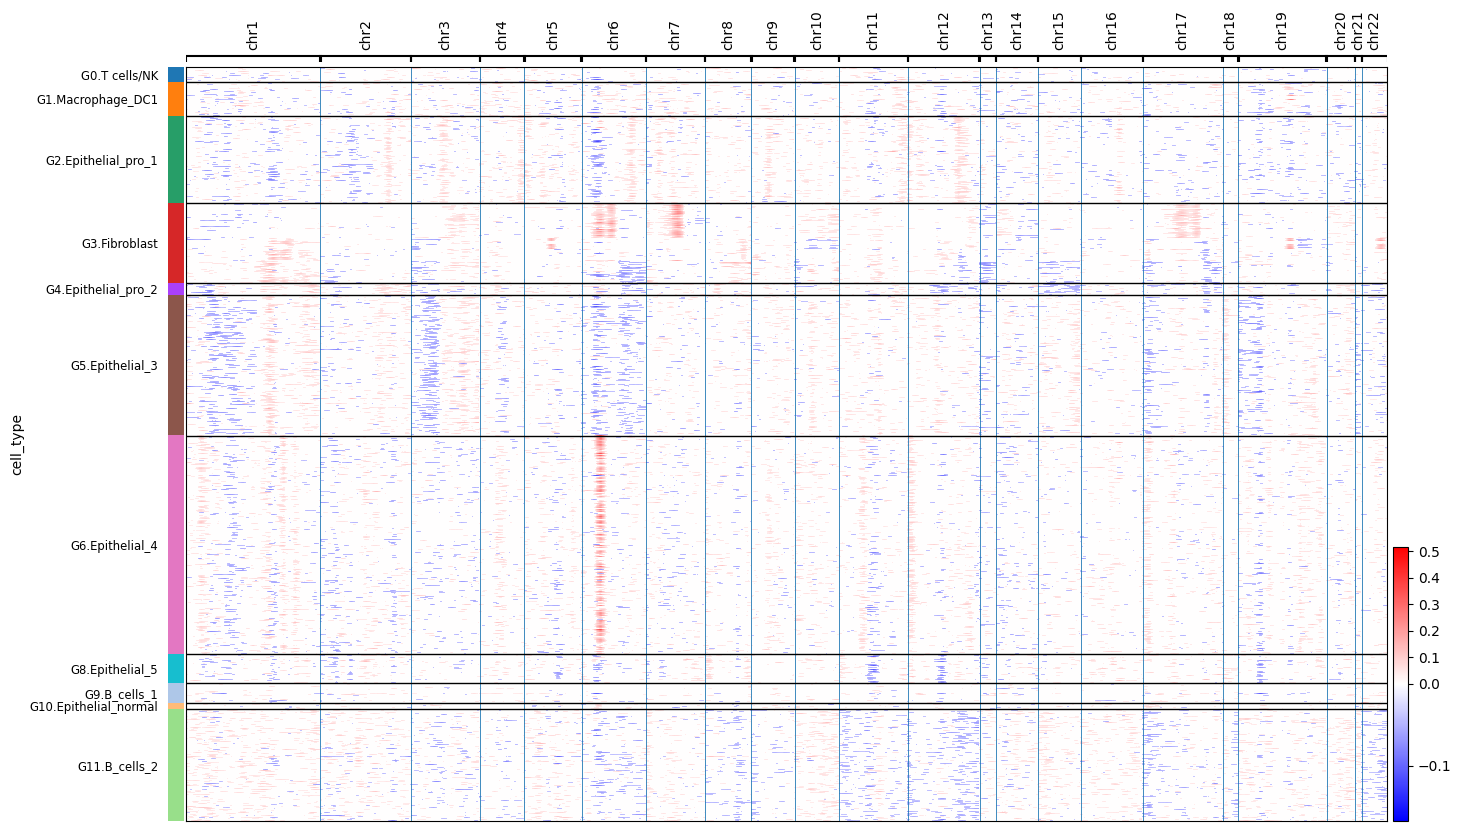

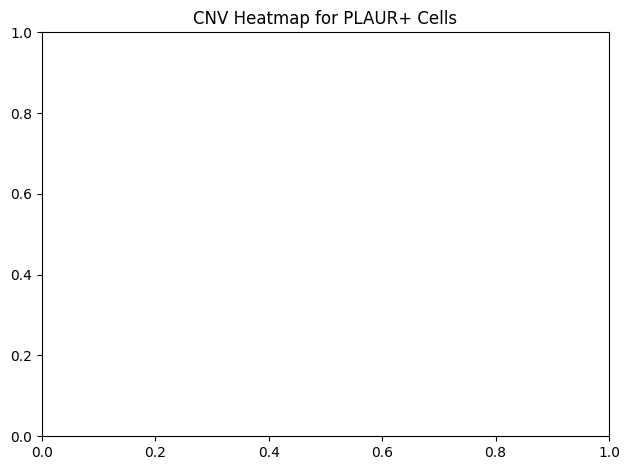

In [28]:
# Plot CNV heatmap for PLAUR+ cells
print("Plotting CNV heatmap for PLAUR+ cells...")
cnv.pl.chromosome_heatmap(
    plaured_positive_cells,          # Data for PLAUR+ cells
    groupby="cell_type"              # Group by cell type for better visualization
)
plt.title('CNV Heatmap for PLAUR+ Cells')
plt.tight_layout()
plt.show()


... storing 'PLAUR_Status_Binary' as categorical


Plotting CNV heatmap for PLAUR- cells...


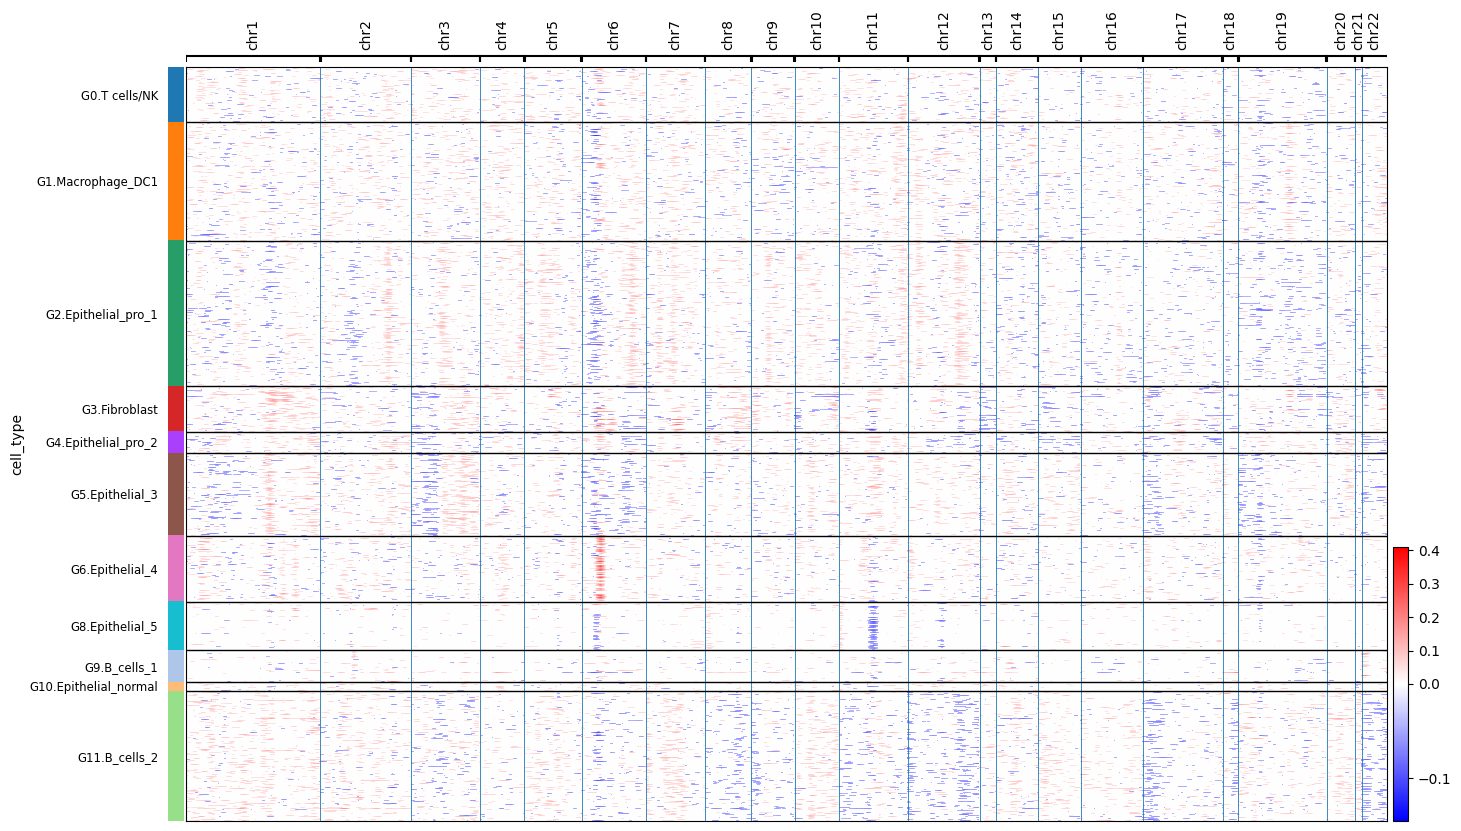

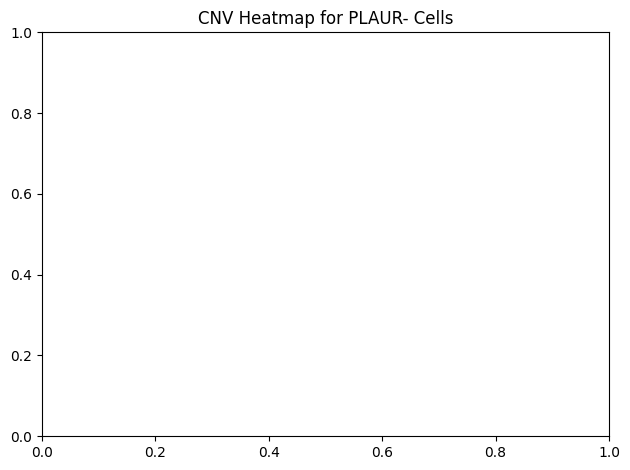

In [29]:
# Plot CNV heatmap for PLAUR- cells
print("Plotting CNV heatmap for PLAUR- cells...")
cnv.pl.chromosome_heatmap(
    plaured_negative_cells,          # Data for PLAUR- cells
    groupby="cell_type"              # Group by cell type for better visualization
)
plt.title('CNV Heatmap for PLAUR- Cells')
plt.tight_layout()
plt.show()

In [30]:
# Step 1: Generate UMAP for CNV in PLAUR+ cells
# UMAP is used to visualize high-dimensional CNV data in a two-dimensional space
cnv.tl.umap(plaured_positive_cells)

# Step 2: Calculate CNV score for PLAUR+ cells
# CNV score provides a metric to evaluate the extent of copy number variations in each cell
cnv.tl.cnv_score(plaured_positive_cells)

# Optional: Verify UMAP and CNV score availability
print("UMAP coordinates and CNV scores calculated for PLAUR+ cells.")


UMAP coordinates and CNV scores calculated for PLAUR+ cells.


... storing 'PLAUR_Status_Binary' as categorical


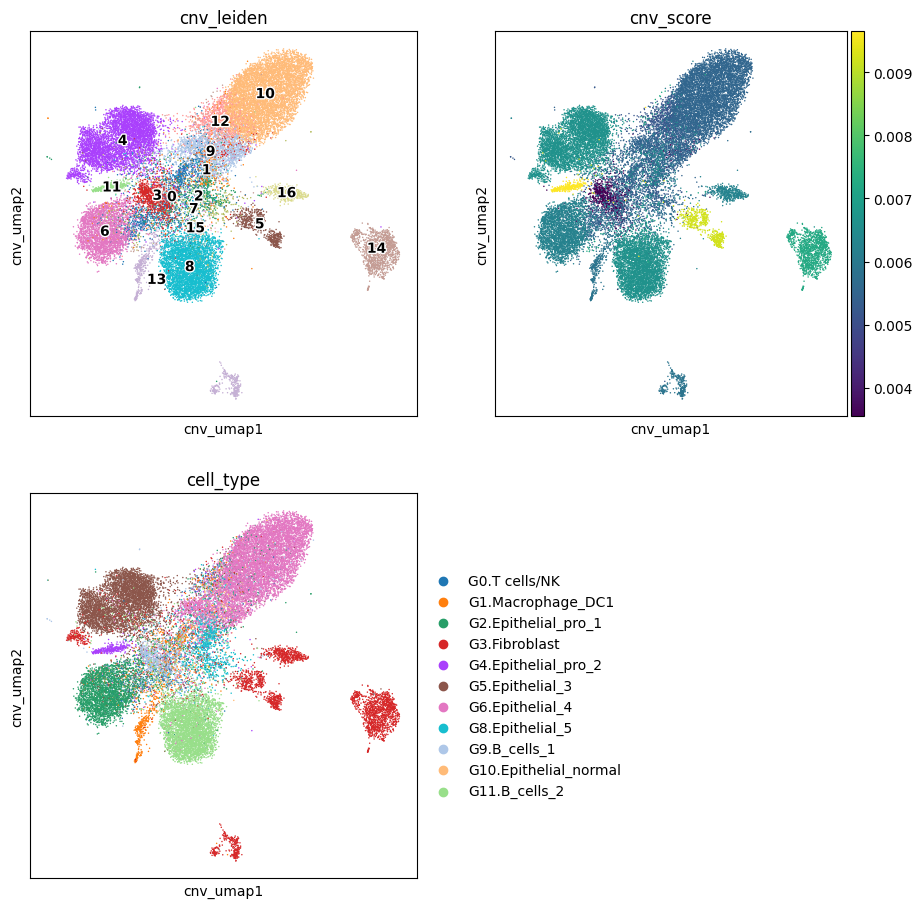

<Figure size 640x480 with 0 Axes>

In [31]:
# Create a 2x2 grid for UMAP visualization, with the bottom-right subplot empty
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")  # Remove axis for bottom-right subplot as it's unused

# UMAP plot colored by CNV Leiden clusters
cnv.pl.umap(
    plaured_positive_cells,
    color="cnv_leiden",           # Color by CNV Leiden clusters
    legend_loc="on data",         # Place legend on the data points
    legend_fontoutline=2,         # Add an outline for better readability
    ax=ax1,                       # Assign to the top-left subplot
    show=False                    # Prevent immediate display
)

# UMAP plot colored by CNV score
cnv.pl.umap(
    plaured_positive_cells,
    color="cnv_score",            # Color by CNV score
    ax=ax2,                       # Assign to the top-right subplot
    show=False                    # Prevent immediate display
)

# UMAP plot colored by cell type
cnv.pl.umap(
    plaured_positive_cells,
    color="cell_type",            # Color by cell type
    ax=ax3                        # Assign to the bottom-left subplot
)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


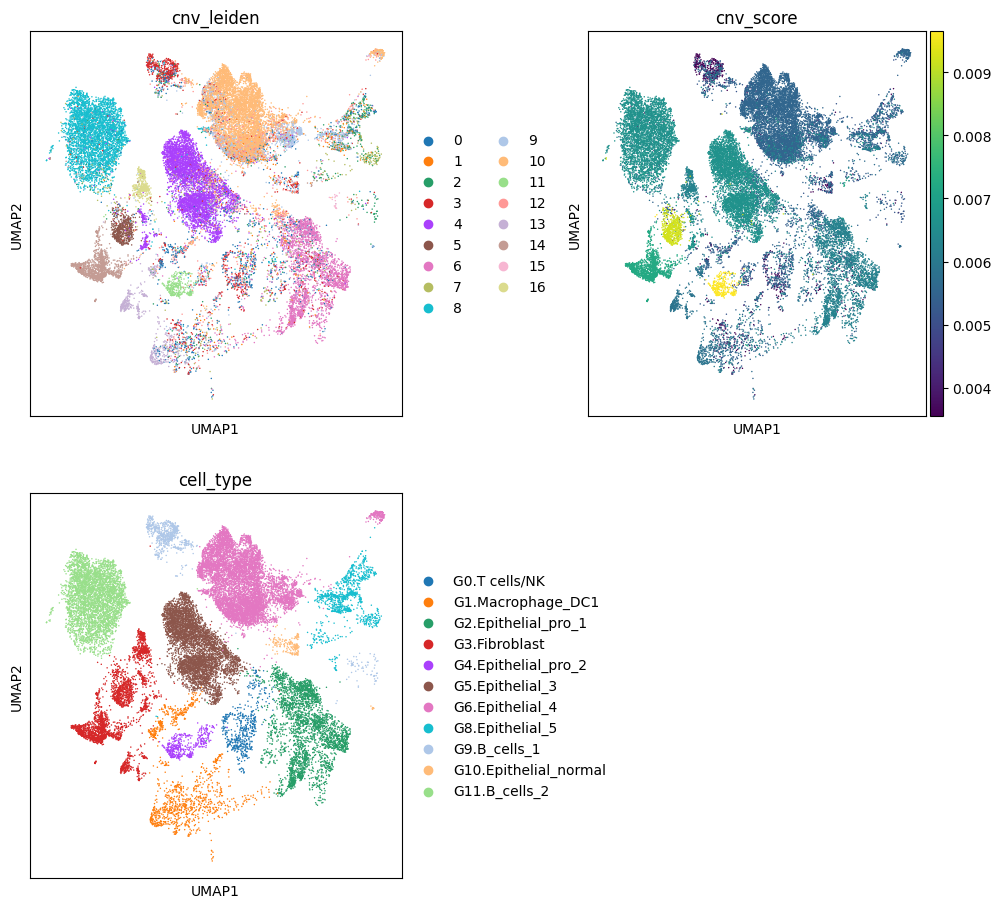

<Figure size 640x480 with 0 Axes>

In [32]:
# Create a 2x2 grid for UMAP visualization with customized horizontal spacing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")  # Remove axis for the bottom-right subplot as it's unused

# UMAP plot colored by CNV Leiden clusters
sc.pl.umap(
    plaured_positive_cells,
    color="cnv_leiden",            # Color by CNV Leiden clusters
    ax=ax1,                        # Assign to the top-left subplot
    show=False                     # Prevent immediate display
)

# UMAP plot colored by CNV score
sc.pl.umap(
    plaured_positive_cells,
    color="cnv_score",             # Color by CNV score
    ax=ax2,                        # Assign to the top-right subplot
    show=False                     # Prevent immediate display
)

# UMAP plot colored by cell type
sc.pl.umap(
    plaured_positive_cells,
    color="cell_type",             # Color by cell type
    ax=ax3                         # Assign to the bottom-left subplot
)

# Adjust layout for optimal spacing
plt.tight_layout()

# Display the plots
plt.show()

In [33]:
# Step 1: Generate UMAP for CNV in PLAUR- cells
# UMAP reduces high-dimensional CNV data to a 2D space for visualization
cnv.tl.umap(plaured_negative_cells)

# Step 2: Calculate CNV score for PLAUR- cells
# CNV score evaluates the extent of copy number variations in each cell
cnv.tl.cnv_score(plaured_negative_cells)

# Optional: Verify that UMAP and CNV score calculations are complete
print("UMAP coordinates and CNV scores calculated for PLAUR- cells.")


UMAP coordinates and CNV scores calculated for PLAUR- cells.


... storing 'PLAUR_Status_Binary' as categorical


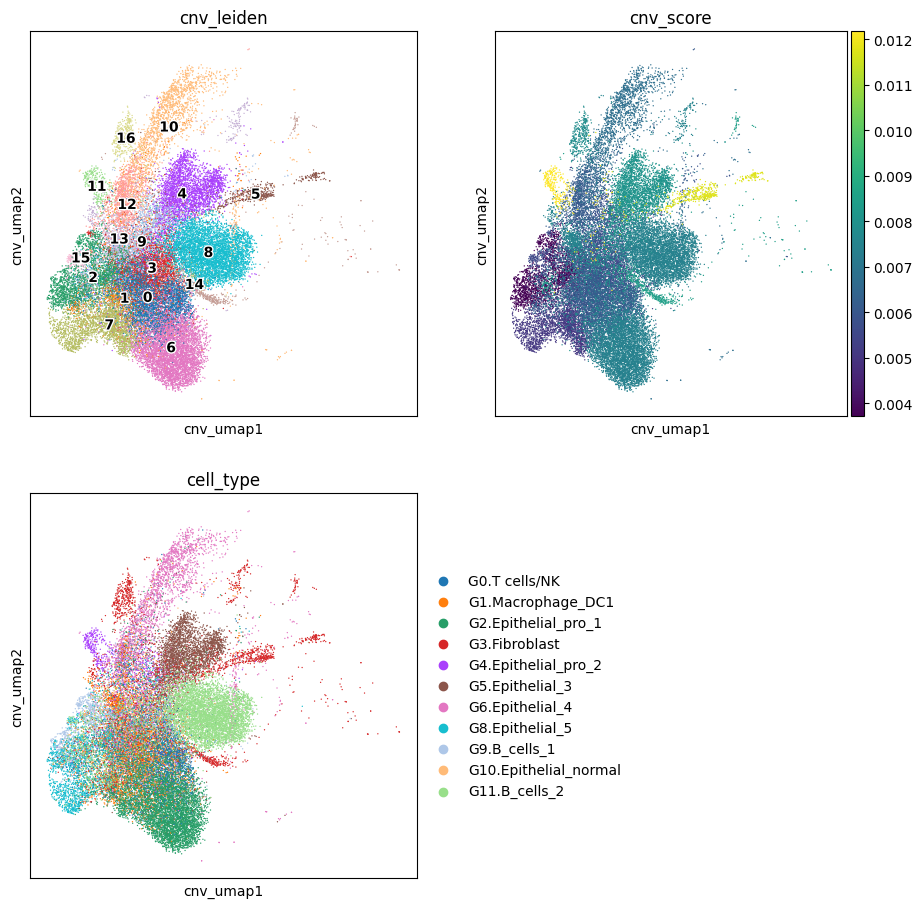

<Figure size 640x480 with 0 Axes>

In [34]:
# Create a 2x2 grid for UMAP visualization, with the bottom-right subplot left empty
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")  # Disable axis for the unused bottom-right subplot

# UMAP plot for PLAUR- cells colored by CNV Leiden clusters
cnv.pl.umap(
    plaured_negative_cells,
    color="cnv_leiden",            # Color by CNV Leiden clusters
    legend_loc="on data",          # Display legend on top of data points
    legend_fontoutline=2,          # Outline legend text for clarity
    ax=ax1,                        # Assign to top-left subplot
    show=False                     # Prevent immediate display
)

# UMAP plot for PLAUR- cells colored by CNV score
cnv.pl.umap(
    plaured_negative_cells,
    color="cnv_score",             # Color by CNV score
    ax=ax2,                        # Assign to top-right subplot
    show=False                     # Prevent immediate display
)

# UMAP plot for PLAUR- cells colored by cell type
cnv.pl.umap(
    plaured_negative_cells,
    color="cell_type",             # Color by cell type
    ax=ax3                         # Assign to bottom-left subplot
)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

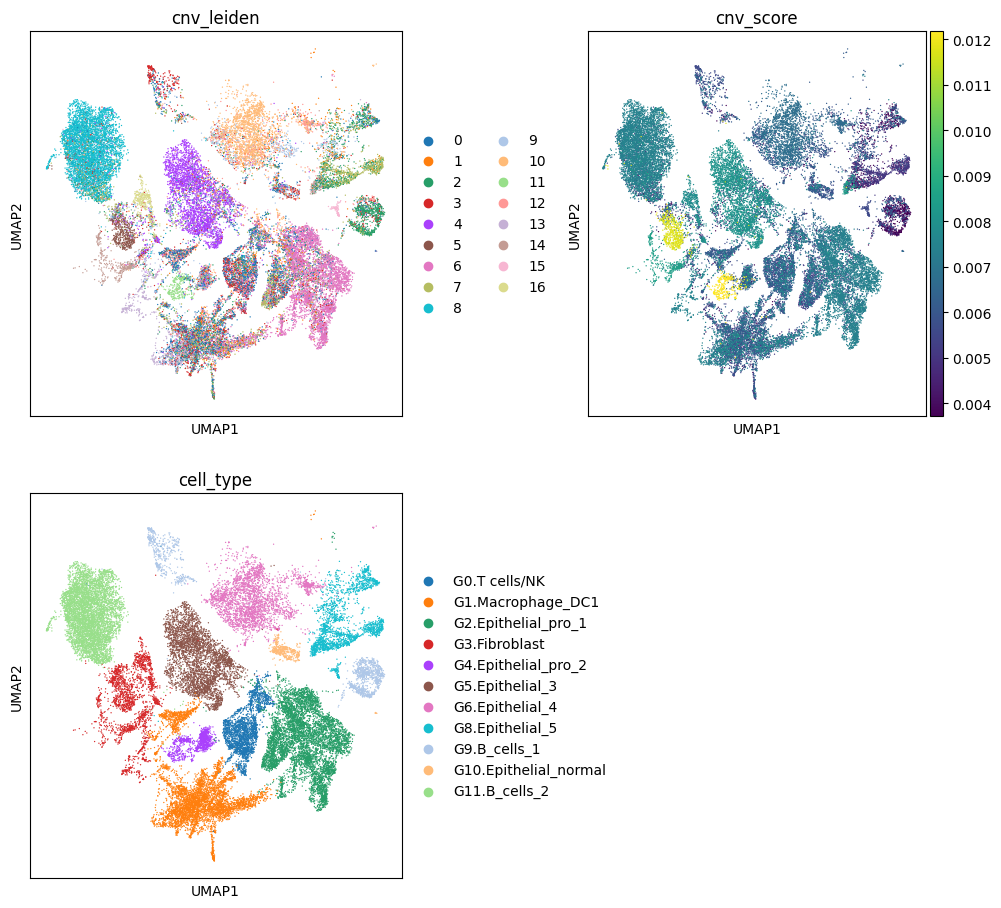

<Figure size 640x480 with 0 Axes>

In [35]:
# Create a 2x2 grid for UMAP visualization with customized horizontal spacing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")  # Disable the axis for the unused bottom-right subplot

# UMAP plot for PLAUR- cells colored by CNV Leiden clusters
sc.pl.umap(
    plaured_negative_cells,
    color="cnv_leiden",            # Color by CNV Leiden clusters
    ax=ax1,                        # Assign to top-left subplot
    show=False                     # Prevent immediate display
)

# UMAP plot for PLAUR- cells colored by CNV score
sc.pl.umap(
    plaured_negative_cells,
    color="cnv_score",             # Color by CNV score
    ax=ax2,                        # Assign to top-right subplot
    show=False                     # Prevent immediate display
)

# UMAP plot for PLAUR- cells colored by cell type
sc.pl.umap(
    plaured_negative_cells,
    color="cell_type",             # Color by cell type
    ax=ax3                         # Assign to bottom-left subplot
)

# Adjust layout for optimal spacing and visual clarity
plt.tight_layout()

# Display the plots
plt.show()

In [37]:
# Step 1: Extract CNV matrices from 'obsm' for PLAUR+ and PLAUR- cells
cnv_matrix_positive = plaured_positive_cells.obsm['X_cnv']
cnv_matrix_negative = plaured_negative_cells.obsm['X_cnv']

# Convert to dense arrays if in sparse format
if not isinstance(cnv_matrix_positive, np.ndarray):
    cnv_matrix_positive = cnv_matrix_positive.toarray()
if not isinstance(cnv_matrix_negative, np.ndarray):
    cnv_matrix_negative = cnv_matrix_negative.toarray()

In [38]:
# Step 2: Calculate average CNV scores for each cell group
# Mean CNV score for each cell across all genes
cnv_scores_positive = cnv_matrix_positive.mean(axis=1)
cnv_scores_negative = cnv_matrix_negative.mean(axis=1)

In [41]:
# Step 3: Perform Mann-Whitney U test to compare CNV distributions between the groups
u_stat, p_value = stats.mannwhitneyu(cnv_scores_positive, cnv_scores_negative, alternative='two-sided')


In [42]:
# Display test results
print("Mann-Whitney U Test for CNV differences between PLAUR+ and PLAUR- cells:")
print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")

Mann-Whitney U Test for CNV differences between PLAUR+ and PLAUR- cells:
U-statistic: 372639289.000, p-value: 1.997e-216


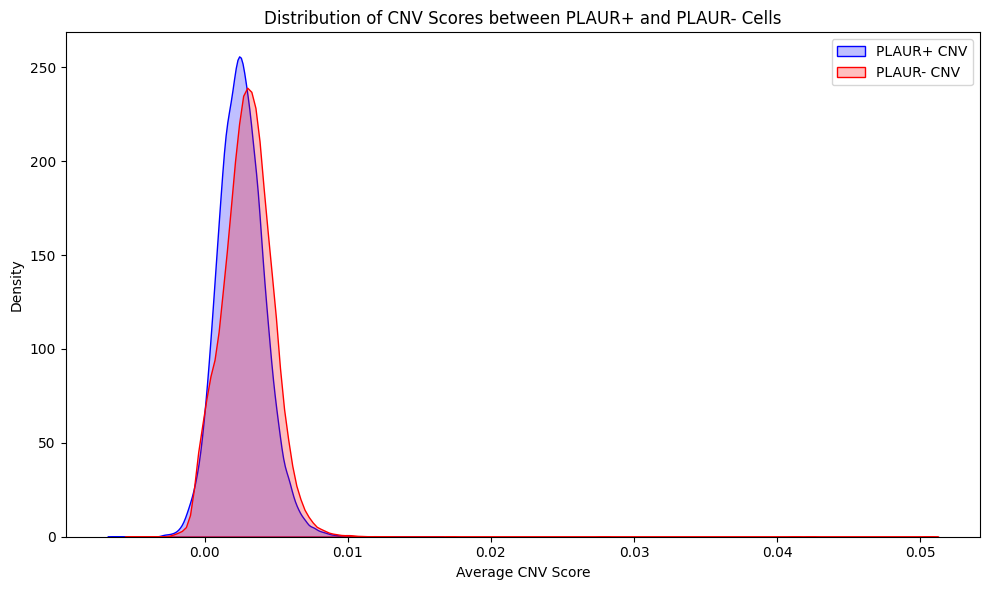

In [43]:
# Step 4: Plot CNV score distributions using KDE plots for each group
plt.figure(figsize=(10, 6))
sns.kdeplot(cnv_scores_positive, label='PLAUR+ CNV', color='blue', fill=True)
sns.kdeplot(cnv_scores_negative, label='PLAUR- CNV', color='red', fill=True)
plt.xlabel('Average CNV Score')
plt.ylabel('Density')
plt.title('Distribution of CNV Scores between PLAUR+ and PLAUR- Cells')
plt.legend()
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


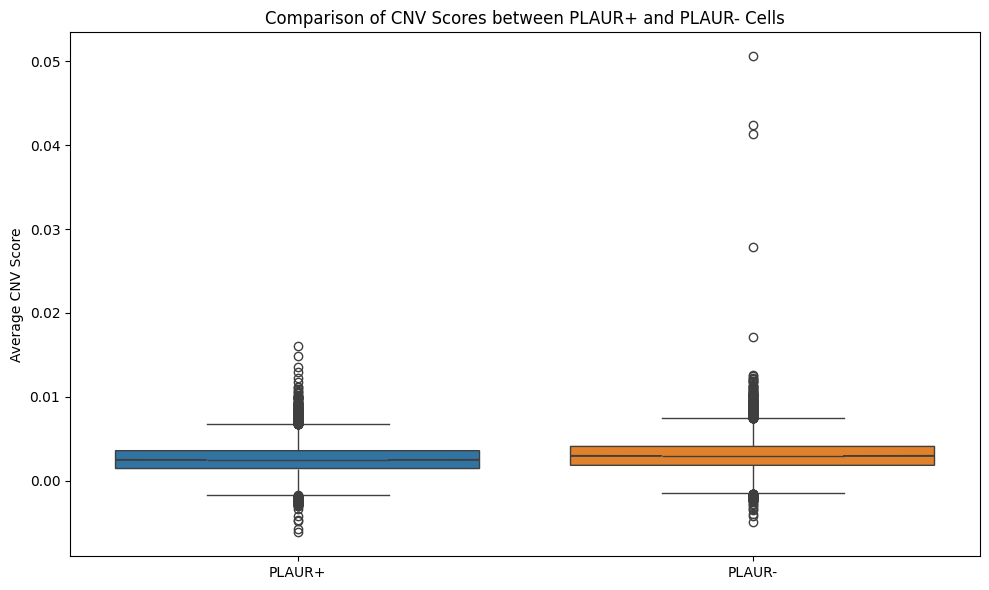

In [44]:
# Step 5: Boxplot to visualize the comparison of CNV scores between groups
plt.figure(figsize=(10, 6))
sns.boxplot(data=[cnv_scores_positive, cnv_scores_negative], notch=True)
plt.xticks([0, 1], ['PLAUR+', 'PLAUR-'])
plt.ylabel('Average CNV Score')
plt.title('Comparison of CNV Scores between PLAUR+ and PLAUR- Cells')
plt.tight_layout()
plt.show()